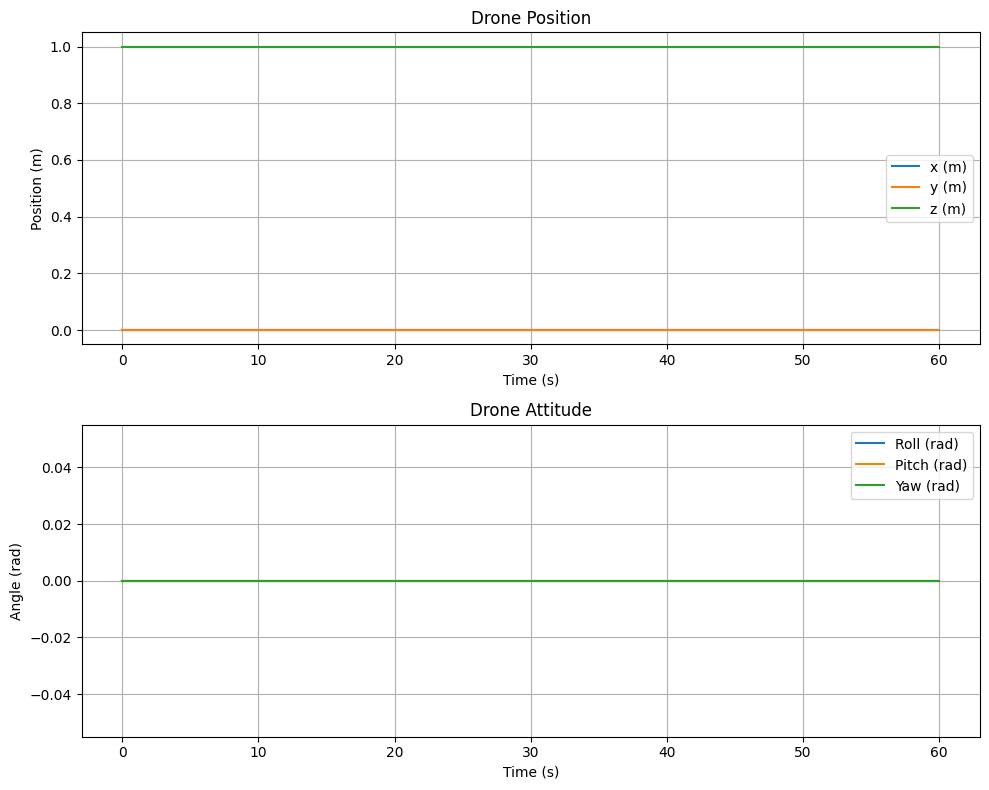

In [1]:
#Performance Goal 1

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Constants
g = 9.81
m = 1.0
l = 0.25
I_x, I_y, I_z = 0.02, 0.02, 0.04
k = 1e-5
b = 1e-7

w = np.sqrt((m*g)/(4*k))
omega = [w, w, w, w]

def quadcopter_dynamics(t, state, omega):
    # State vector: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    omega1, omega2, omega3, omega4 = omega

    T1 = k*(omega1**2)
    T2 = k*(omega2**2)
    T3 = k*(omega3**2)
    T4 = k*(omega4**2)
    F_z = T1 + T2 + T3 + T4
    tau_x = l * (T1 - T3)
    tau_y = l * (T2 - T4)
    tau_z = b * (omega1**2 - omega2**2 + omega3**2 - omega4**2)  # Yaw torque = 0

    # Translational dynamics
    R_bi = rotation_matrix(phi, theta, psi)
    acc = (1/m) * (R_bi @ np.array([0, 0, F_z]) - np.array([0, 0, m * g]))
    ax, ay, az = acc

    # Rotational acceleration
    dp = (tau_x - (I_z - I_y) * q * r) / I_x
    dq = (tau_y - (I_x - I_z) * r * p) / I_y
    dr = (tau_z - (I_y - I_x) * p * q) / I_z

    # Rotational velocities
    dphi = p + q * np.sin(phi) * np.tan(theta) + r * np.cos(phi) * np.tan(theta)
    dtheta = q * np.cos(phi) - r * np.sin(phi)
    dpsi = q * np.sin(phi) / np.cos(theta) + r * np.cos(phi) / np.cos(theta)

    return [vx, vy, vz, ax, ay, az, dphi, dtheta, dpsi, dp, dq, dr]

def rotation_matrix(phi, theta, psi):
    """Rotation matrix from body frame to inertial frame."""
    R = np.array([
        [
            np.cos(psi) * np.cos(theta),
            np.cos(psi) * np.sin(theta) * np.sin(phi) - np.sin(psi) * np.cos(phi),
            np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi)
        ],
        [
            np.sin(psi) * np.cos(theta),
            np.sin(psi) * np.sin(theta) * np.sin(phi) + np.cos(psi) * np.cos(phi),
            np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi)
        ],
        [
            -np.sin(theta),
            np.cos(theta) * np.sin(phi),
            np.cos(theta) * np.cos(phi)
        ]
    ])
    return R

initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]


t_span = (0, 60)
t_eval = np.linspace(*t_span, 1000)


sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, t_eval=t_eval, args=(omega,), method='RK45')


x, y, z = sol.y[0], sol.y[1], sol.y[2]
phi, theta, psi = sol.y[6], sol.y[7], sol.y[8]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot position over time
axs[0].plot(sol.t, x, label='x (m)')
axs[0].plot(sol.t, y, label='y (m)')
axs[0].plot(sol.t, z, label='z (m)')
axs[0].set_title('Drone Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid()

# Plot attitude over time
axs[1].plot(sol.t, phi, label='Roll (rad)')
axs[1].plot(sol.t, theta, label='Pitch (rad)')
axs[1].plot(sol.t, psi, label='Yaw (rad)')
axs[1].set_title('Drone Attitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


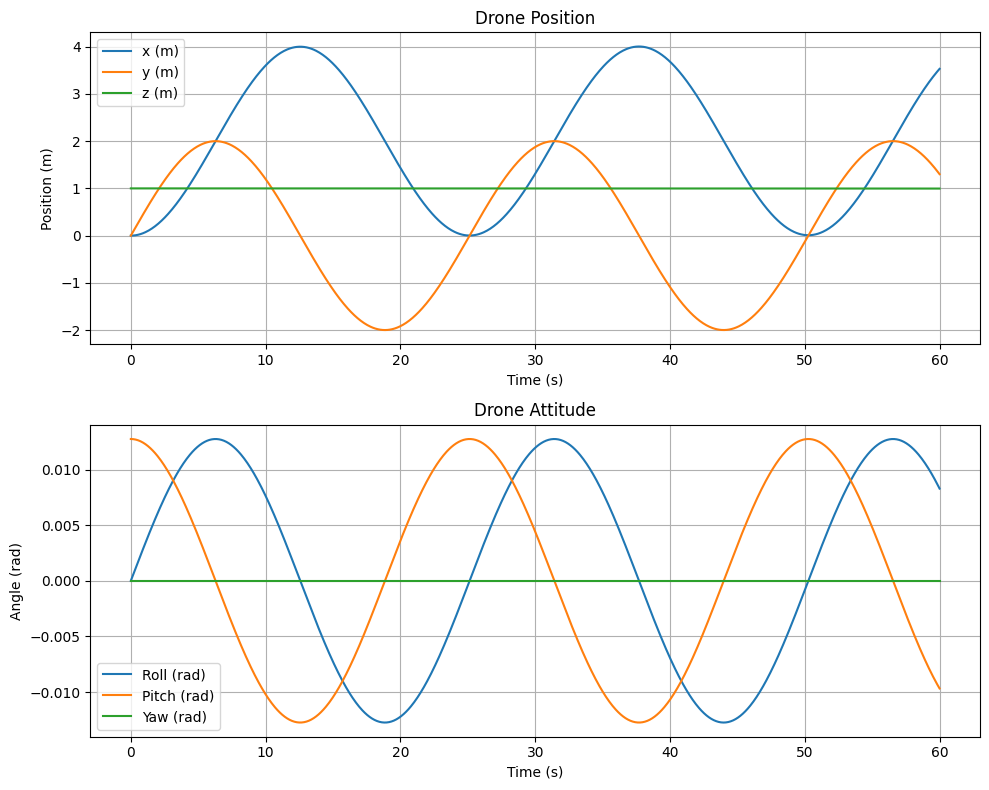

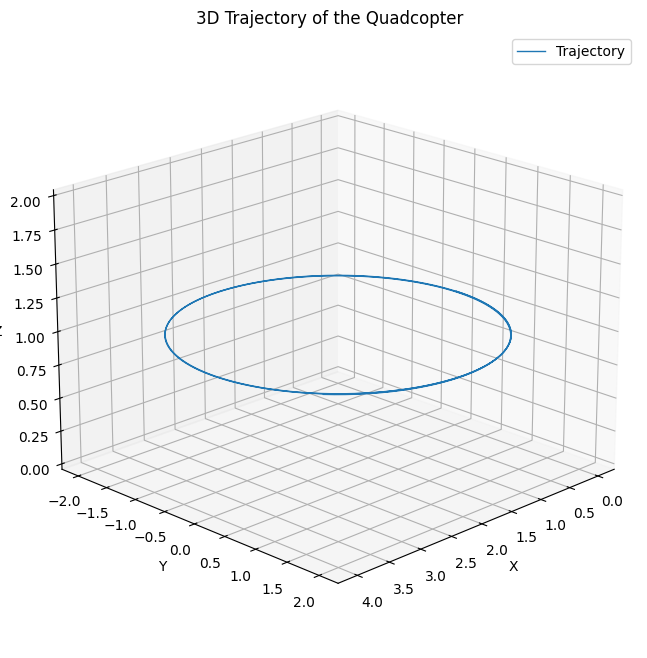

In [2]:
# Performance Goal 2

# FINAL CODE FOR GOAL 2

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
g = 9.81
m = 1.72978
l = 0.25
I_x, I_y, I_z = 0.02, 0.02, 0.04
k = 1e-5
b = 1e-7
v = 0.5 # desired velocity for performance goal 2
w_hover = np.sqrt((m * g) / (4 * k)) - 0.0265 # hovering RPM

R = 2.0  # radius of the circle (m)
omega_c = v/R  # Angular velocity of the circle (rad/s)

def angular_velocity(t):
    p = np.arctan2(v**2,R*g) * omega_c * np.cos(omega_c * t)
    q = -np.arctan2(v**2,R*g) * omega_c * np.sin(omega_c * t)
    r = 0

    return p, q, r

def rotor_speeds(t):
    phi_t = roll_angle(t)
    theta_t = pitch_angle(t)

    omega1 = w_hover * (1 - phi_t + theta_t)
    omega2 = w_hover * (1 - phi_t - theta_t)
    omega3 = w_hover * (1 + phi_t - theta_t)
    omega4 = w_hover * (1 + phi_t + theta_t)

    return [omega1, omega2, omega3, omega4]

def pitch_angle(t):
    return np.arctan2(v**2,R*g) * np.cos(omega_c * t)

def roll_angle(t):
    return -np.arctan2(v**2,R*g) * np.sin(omega_c * t)

def quadcopter_dynamics(t, state):
    # state vector
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state

    p, q, r = angular_velocity(t)
    omega1, omega2, omega3, omega4 = rotor_speeds(t)

    T1 = k * (omega1 ** 2)
    T2 = k * (omega2 ** 2)
    T3 = k * (omega3 ** 2)
    T4 = k * (omega4 ** 2)
    F_z = T1 + T2 + T3 + T4
    tau_x = l * (T1 - T3)
    tau_y = l * (T2 - T4)
    tau_z = b * (omega1 ** 2 - omega2 ** 2 + omega3 ** 2 - omega4 ** 2)

    # translational
    R_bi = rotation_matrix(phi, theta, psi)
    acc = (1 / m) * (R_bi @ np.array([0, 0, F_z]) - np.array([0, 0, m * g]))
    ax, ay, az = acc

    # rotational accelerations
    dp = (tau_x - (I_z - I_y) * q * r) / I_x
    dq = (tau_y - (I_x - I_z) * r * p) / I_y
    dr = (tau_z - (I_y - I_x) * p * q) / I_z

    # rotational velocities
    dphi = p + q * np.sin(phi) * np.tan(theta) + r * np.cos(phi) * np.tan(theta)
    dtheta = q * np.cos(phi) - r * np.sin(phi)
    dpsi = 0

    return [vx, vy, vz, ax, ay, az, dphi, dtheta, dpsi, dp, dq, dr]

def rotation_matrix(phi, theta, psi):
    R = np.array([
        [
            np.cos(psi) * np.cos(theta),
            np.cos(psi) * np.sin(theta) * np.sin(phi) - np.sin(psi) * np.cos(phi),
            np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi)
        ],
        [
            np.sin(psi) * np.cos(theta),
            np.sin(psi) * np.sin(theta) * np.sin(phi) + np.cos(psi) * np.cos(phi),
            np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi)
        ],
        [
            -np.sin(theta),
            np.cos(theta) * np.sin(phi),
            np.cos(theta) * np.cos(phi)
        ]
    ])
    return R

# Initial state
initial_state = [0, 0, 1, 0, 0.5, 0, roll_angle(0), pitch_angle(0), 0, angular_velocity(0)[0], angular_velocity(0)[1], angular_velocity(0)[2]]

# Time span
t_span = (0, 60)
t_eval = np.linspace(*t_span, 1000)

# Solve
sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, t_eval=t_eval, method='RK45', rtol=1e-12, atol=1e-12)

# Get solutions
x, y, z = sol.y[0], sol.y[1], sol.y[2]
phi, theta, psi = sol.y[6], sol.y[7], sol.y[8]


fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# position over time
axs[0].plot(sol.t, x, label='x (m)')
axs[0].plot(sol.t, y, label='y (m)')
axs[0].plot(sol.t, z, label='z (m)')
axs[0].set_title('Drone Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid()

# attitude over time
axs[1].plot(sol.t, phi, label='Roll (rad)')
axs[1].plot(sol.t, theta, label='Pitch (rad)')
axs[1].plot(sol.t, psi, label='Yaw (rad)')
axs[1].set_title('Drone Attitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# 3D Trajectory Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Trajectory', linewidth=1)
ax.view_init(elev=20, azim=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([0, 2])
ax.set_title('3D Trajectory of the Quadcopter')
ax.legend()
plt.show()

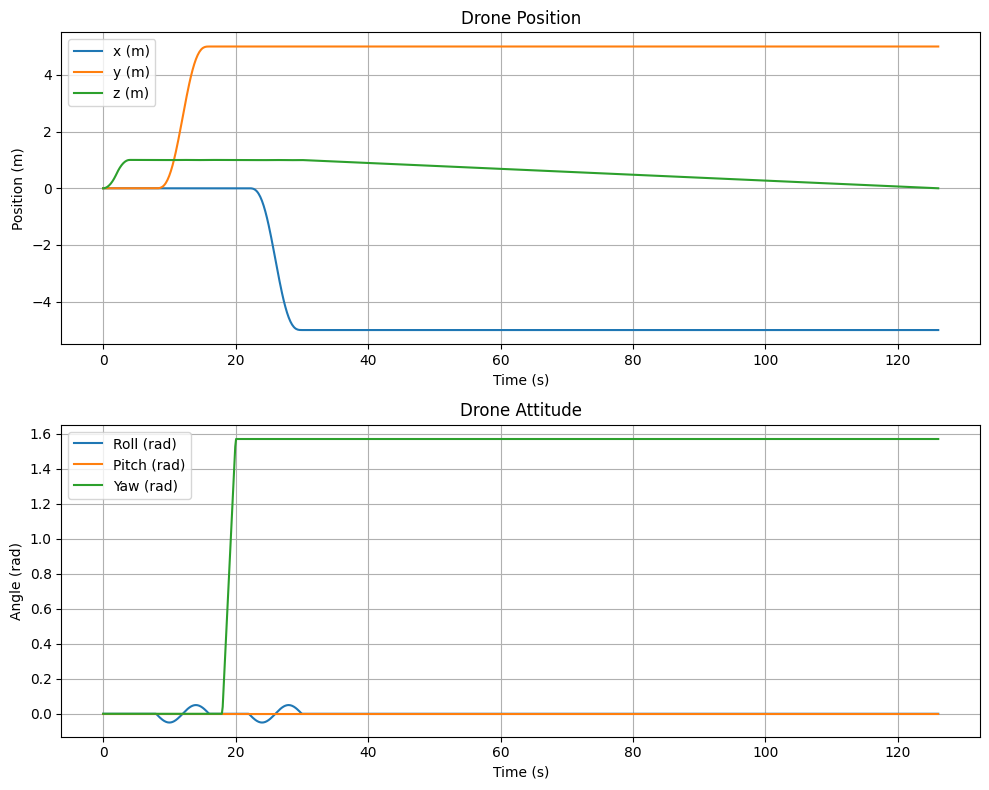

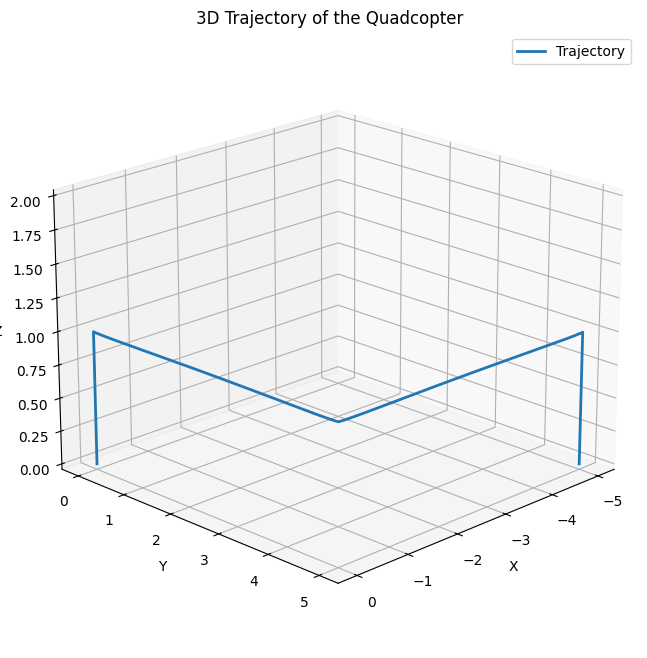

In [3]:
# Performance Goal 3 (Bonus)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


g = 9.81
m = 1.0
l = 0.25
I_x, I_y, I_z = 0.02, 0.02, 0.04
k = 1e-5
b = 1e-7
v = 0.5
r = 2
w_hover = np.sqrt((m*g)/(4*k))
w_up = np.sqrt((0.25*m + m*g)/(4*k))
w_down = np.sqrt((-0.25*m + m*g)/(4*k))


def angular_velocity_ascend(t):
    p = 0
    q = 0
    r = 0

    return p, q, r


def rotor_speeds_vertical(t):
    if (t <= 2):
        omega1 = omega2 = omega3 = omega4 = w_up
    if (2 < t <= 4):
        omega1 = omega2 = omega3 = omega4 = w_down
    if (4 < t <= 30):
        omega1 = omega2 = omega3 = omega4 = w_hover
    if (30 < t <= 30.04):
        omega1 = omega2 = omega3 = omega4 = w_down
    if (30.04 < t):
        omega1 = omega2 = omega3 = omega4 = w_hover


    return [omega1, omega2, omega3, omega4]


def pitch_angle_ascend(t):
    return 0

def roll_angle_ascend(t):
    return 0

def rotation_matrix(phi, theta, psi):
    R = np.array([
        [
            np.cos(psi) * np.cos(theta),
            np.cos(psi) * np.sin(theta) * np.sin(phi) - np.sin(psi) * np.cos(phi),
            np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi)
        ],
        [
            np.sin(psi) * np.cos(theta),
            np.sin(psi) * np.sin(theta) * np.sin(phi) + np.cos(psi) * np.cos(phi),
            np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi)
        ],
        [
            -np.sin(theta),
            np.cos(theta) * np.sin(phi),
            np.cos(theta) * np.cos(phi)
        ]
    ])
    return R




#############################################################################################################################


def angular_velocity_horiz(t):
    omega_c = np.pi/4
    p = -0.05 * omega_c * np.cos(omega_c * t)
    q = 0
    r = 0

    return p, q, r


def rotor_speeds_horiz(t):
    phi_t = roll_angle_horiz(t)

    omega1 = (w_hover - 0.155) * (1 - phi_t)
    omega2 = (w_hover - 0.155) * (1 - phi_t)
    omega3 = (w_hover - 0.155) * (1 + phi_t)
    omega4 = (w_hover - 0.155) * (1 + phi_t)

    return [omega1, omega2, omega3, omega4]



def angular_velocity_turn(t):
    omega_c = np.pi/4
    p = 0
    q = 0
    r = omega_c

    return p, q, r


def rotor_speeds_turn(t):
    phi_t = roll_angle_horiz(t)

    omega1 = (w_hover - 0.155)
    omega2 = (w_hover + 0.155)
    omega3 = (w_hover - 0.155)
    omega4 = (w_hover + 0.155)

    return [omega1, omega2, omega3, omega4]




def roll_angle_horiz(t):
    omega_c = np.pi/4
    return -0.05 * np.sin(omega_c * t)


def quadcopter_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state


    if ((t <= 8)):
        p, q, r = angular_velocity_ascend(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_vertical(t)
    if (8 < t <= 16):
        p, q, r = angular_velocity_horiz(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_horiz(t)
    if (16 < t <= 18):
        p, q, r = angular_velocity_ascend(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_vertical(t)
    if (18 < t <= 20):
        p, q, r = angular_velocity_turn(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_turn(t)
    if (20 < t <= 22):
        p, q, r = angular_velocity_ascend(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_vertical(t)
    if (22 < t <= 30):
        p, q, r = angular_velocity_horiz(t-14)
        omega1, omega2, omega3, omega4 = rotor_speeds_horiz(t-14)
    if (t > 30):
        p, q, r = angular_velocity_ascend(t)
        omega1, omega2, omega3, omega4 = rotor_speeds_vertical(t)


    T1 = k * (omega1 ** 2)
    T2 = k * (omega2 ** 2)
    T3 = k * (omega3 ** 2)
    T4 = k * (omega4 ** 2)
    F_z = T1 + T2 + T3 + T4
    tau_x = l * (T1 - T3)
    tau_y = l * (T2 - T4)
    tau_z = b * (omega1 ** 2 - omega2 ** 2 + omega3 ** 2 - omega4 ** 2)


    R_bi = rotation_matrix(phi, theta, psi)
    acc = (1 / m) * (R_bi @ np.array([0, 0, F_z]) - np.array([0, 0, m * g]))
    ax, ay, az = acc


    dp = (tau_x - (I_z - I_y) * q * r) / I_x
    dq = (tau_y - (I_x - I_z) * r * p) / I_y
    dr = (tau_z - (I_y - I_x) * p * q) / I_z

    dphi = p + q * np.sin(phi) * np.tan(theta) + r * np.cos(phi) * np.tan(theta)
    dtheta = q * np.cos(phi) - r * np.sin(phi)
    dpsi = q * np.sin(phi) / np.cos(theta) + r * np.cos(phi) / np.cos(theta)

    return [vx, vy, vz, ax, ay, az, dphi, dtheta, dpsi, dp, dq, dr]




#########################################################################################################################



initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


t_span = (0, 126.1)
t_eval = np.linspace(*t_span, 1000)


sol = solve_ivp(quadcopter_dynamics, t_span, initial_state, t_eval=t_eval, method='RK45', rtol=1e-13, atol=1e-13)


x, y, z = sol.y[0], sol.y[1], sol.y[2]
phi, theta, psi = sol.y[6], sol.y[7], sol.y[8]



fig, axs = plt.subplots(2, 1, figsize=(10, 8))


axs[0].plot(sol.t, x, label='x (m)')
axs[0].plot(sol.t, y, label='y (m)')
axs[0].plot(sol.t, z, label='z (m)')
axs[0].set_title('Drone Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid()


axs[1].plot(sol.t, phi, label='Roll (rad)')
axs[1].plot(sol.t, theta, label='Pitch (rad)')
axs[1].plot(sol.t, psi, label='Yaw (rad)')
axs[1].set_title('Drone Attitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Trajectory', linewidth=2)
ax.view_init(elev=20, azim=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([0, 2])
ax.set_title('3D Trajectory of the Quadcopter')
ax.legend()
plt.show()

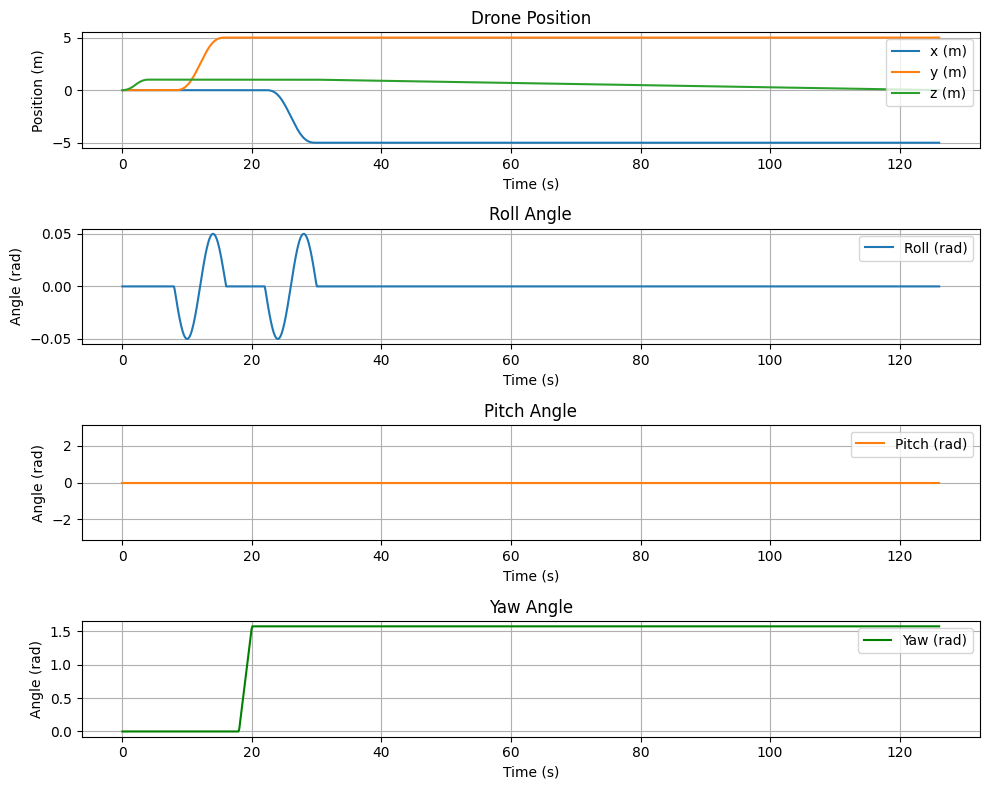

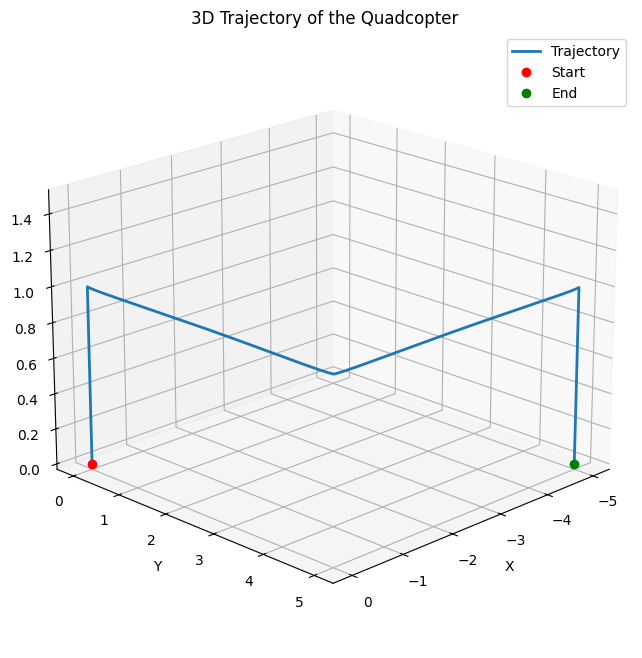

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))


axs[0].plot(sol.t, x, label='x (m)')
axs[0].plot(sol.t, y, label='y (m)')
axs[0].plot(sol.t, z, label='z (m)')
axs[0].set_title('Drone Position')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid()


axs[1].plot(sol.t, phi, label='Roll (rad)')
axs[1].set_title('Roll Angle')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid()

axs[2].plot(sol.t, theta, 'tab:orange', label='Pitch (rad)')
axs[2].set_title('Pitch Angle')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angle (rad)')
axs[2].set_ylim([-np.pi, np.pi])
axs[2].legend()
axs[2].grid()

axs[3].plot(sol.t, psi, 'g', label='Yaw (rad)')
axs[3].set_title('Yaw Angle')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Angle (rad)')
axs[3].legend()
axs[3].grid()

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Trajectory', linewidth=2)
ax.plot(0, 0, 0, 'ro', label='Start')
ax.plot(-5, 5, 0, 'go', label='End')
ax.view_init(elev=20, azim=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([0, 1.5])
ax.set_title('3D Trajectory of the Quadcopter')
ax.legend()
plt.show()